# Import needed packages

In [1]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [4]:
import numpy as np
import pandas as pd

In [5]:
import cv2

# Load slides as test set

After checking differnt slides left, I chose to use slides 110 as the final test set, since like slides 001 and 002 hardly contains canerous cells.

I will try to use the second model with different zoom levels but no seperation training as the first test model. The mian reason is that it reach a better accurarcy. I will also try to use the original model with data augmentation as the benchmark.

## Load data from google drive

In [6]:
slide_path = '/content/drive/MyDrive/tumor_110.tif' 
tumor_mask_path = '/content/drive/MyDrive/tumor_110_mask.tif' 

slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

In [7]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

## Have a quick look at the test data

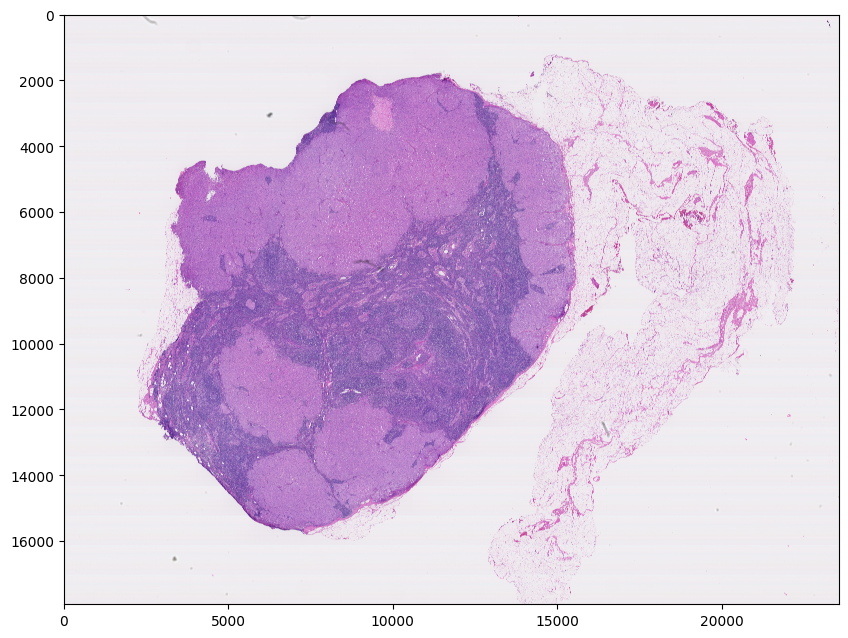

In [ ]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=2, 
                         width=slide.level_dimensions[2][0], 
                         height=slide.level_dimensions[2][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

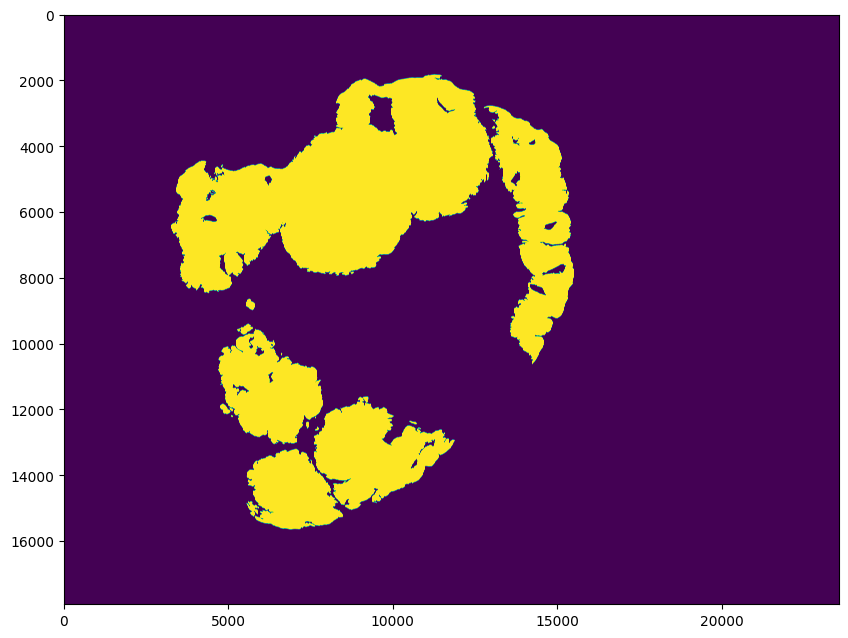

In [ ]:
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=2, 
                        width=slide.level_dimensions[2][0], 
                        height=slide.level_dimensions[2][1])

mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

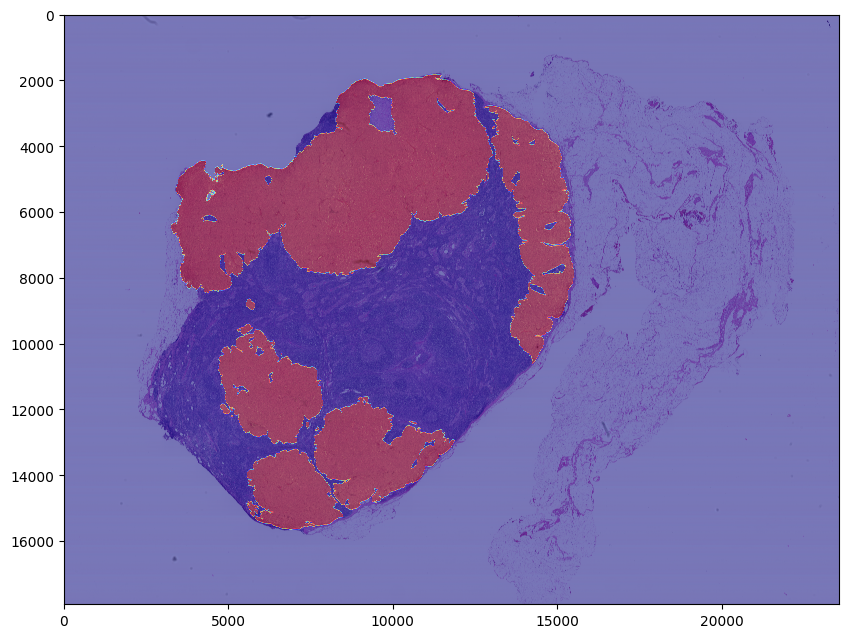

In [ ]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [8]:
total_true = 0
for i in range(0,slide.level_dimensions[0][1],600):
  for j in range(0,slide.level_dimensions[0][0],600):
    mask = read_slide(tumor_mask, 
                         x=j, 
                         y=i, 
                         level=2, 
                         width=150, 
                         height=150)
    mask = mask[:,:,0]
    total_true += sum(sum(mask))

# Load the model

In [9]:
model_bench = tf.keras.models.load_model(
    '/content/drive/MyDrive/project_model/original_without_data_augmentation.h5')
model_bench.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [10]:
model =tf.keras.models.load_model('/content/drive/MyDrive/project_model/diffent_without_seperate.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [11]:
def find_percentage_tissue_pixels(image,width=150,height=150,intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    result = list(zip(indices[0], indices[1]))
    percentage = len(result) / float(width * height) * 100
    return percentage

# Predict with the basic model

In [12]:
bench = []

In [13]:
count_zero_bench = 0
count_one_bench = 0 
count_true_bench = 0
for i in range(0,slide.level_dimensions[0][1],600):
  for j in range(0,slide.level_dimensions[0][0],600):
    img = read_slide(slide, 
                         x=j, 
                         y=i, 
                         level=2, 
                         width=150, 
                         height=150)
    im_batch = tf.expand_dims(img,0)
    batch_pred = list(model_bench.predict(im_batch)[0])[0]
    tmp = int(0)
    if find_percentage_tissue_pixels(img,width=150,height=150,intensity=0.8) < 0.5:
      bench.append(tmp)
      count_zero_bench += 1
      continue
    if batch_pred >= 0.5:
      tmp = int(1)
      count_one_bench += 1
      mask = read_slide(tumor_mask, 
                         x=j, 
                         y=i, 
                         level=2, 
                         width=150, 
                         height=150)
      mask = mask[:,:,0]
      count_true_bench += sum(sum(mask))
    else:
      tmp = int(0)
      count_zero_bench +=1
    bench.append(tmp)

In [14]:
print("There are %d patches predicted with cancerous cells, taking %.2f percent. "%(count_one_bench,
                                                                           count_one_bench/(count_one_bench+count_zero_bench)*100))
print("There are %d patches predicted without cancerous cells, taking %.2f percent. "%(count_zero_bench,
                                                                           count_zero_bench/(count_one_bench+count_zero_bench)*100))

There are 8700 patches predicted with cancerous cells, taking 45.89 percent. 
There are 10260 patches predicted without cancerous cells, taking 54.11 percent. 


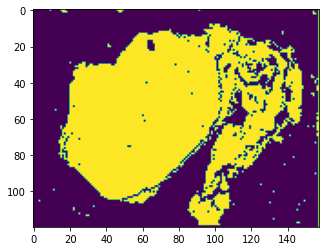

In [15]:
bench_show = np.reshape(bench[:18960], (120, 158))
plt.imshow(bench_show)

In [16]:
df = pd.DataFrame(bench)
df.to_csv('/content/drive/MyDrive/basic_prediction_new.csv')

In [17]:
count_true_bench/total_true

0.9946498136084099

# Predicted with model with higher validation accuracy

In [18]:
new = []

In [19]:
count_zero = 0
count_one = 0 
count_true = 0
for i in range(0,slide.level_dimensions[0][1],600):
  for j in range(0,slide.level_dimensions[0][0],600):
    img = read_slide(slide, 
                         x=j, 
                         y=i, 
                         level=2, 
                         width=150, 
                         height=150)
    tmp = int(0)
    if find_percentage_tissue_pixels(img,width=150,height=150,intensity=0.8) < 0.5:
      new.append(tmp)
      count_zero += 1
      continue
    im_batch = tf.expand_dims(img,0)
    batch_pred = list(model.predict(im_batch)[0])[0]
    if batch_pred >= 0.5:
      tmp = int(1)
      count_one += 1
      mask = read_slide(tumor_mask, 
                         x=j, 
                         y=i, 
                         level=2, 
                         width=150, 
                         height=150)
      mask = mask[:,:,0]
      count_true += sum(sum(mask))
    else:
      tmp = int(0)
      count_zero +=1
    new.append(tmp)

In [20]:
print("There are %d patches predicted with cancerous cells, taking %.2f percent. "%(count_one,
                                                                           count_one/(count_one+count_zero)*100))
print("There are %d patches predicted without cancerous cells, taking %.2f percent. "%(count_zero,
                                                                           count_zero/(count_one+count_zero)*100))

There are 1395 patches predicted with cancerous cells, taking 7.36 percent. 
There are 17565 patches predicted without cancerous cells, taking 92.64 percent. 


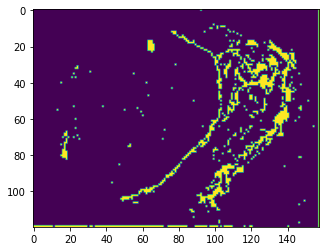

In [21]:
new = np.reshape(new[:18960], (120, 158))
plt.imshow(new)

In [22]:
df = pd.DataFrame(new)
df.to_csv('/content/drive/MyDrive/better_model_prediction_new.csv')

In [23]:
count_true/total_true

0.014597315742247059

# Combine these two models

In [24]:
combine = []

In [25]:
count_zero_combine = 0
count_one_combine = 0 
count_true_combine = 0
for i in range(0,slide.level_dimensions[0][1],600):
  for j in range(0,slide.level_dimensions[0][0],600):
    img = read_slide(slide, 
                         x=j, 
                         y=i, 
                         level=2, 
                         width=150, 
                         height=150)
    tmp = int(0)
    if find_percentage_tissue_pixels(img,width=150,height=150,intensity=0.8) < 0.5:
      combine.append(tmp)
      count_zero_combine += 1
      continue
    im_batch = tf.expand_dims(img,0)
    batch_pred_bench = list(model_bench.predict(im_batch)[0])[0]
    batch_pred_better = list(model.predict(im_batch)[0])[0]
    batch_pred = (batch_pred_bench+batch_pred_better)/2
    if batch_pred >= 0.5001:
      tmp = int(1)
      count_one_combine += 1
      mask = read_slide(tumor_mask, 
                         x=j, 
                         y=i, 
                         level=2, 
                         width=150, 
                         height=150)
      mask = mask[:,:,0]
      count_true_combine += sum(sum(mask))
    else:
      tmp = int(0)
      count_zero_combine +=1
    combine.append(tmp)

In [ ]:
print("There are %d patches predicted with cancerous cells, taking %.2f percent. "%(count_one_combine,
                                                                           count_one_combine/(count_one_combine+count_zero_combine)*100))
print("There are %d patches predicted without cancerous cells, taking %.2f percent. "%(count_zero_combine,
                                                                           count_zero_combine/(count_one_combine+count_zero_combine)*100))

There are 513 patches predicted with cancerous cells, taking 2.71 percent. 
There are 18447 patches predicted without cancerous cells, taking 97.29 percent. 


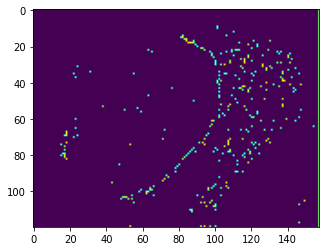

In [26]:
combine_plot = np.reshape(combine[:18960], (120, 158))
plt.imshow(combine_plot)

In [27]:
count_true_combine/total_true

0.009253679805267598

In [28]:
count_zero_combine = 0
count_one_combine = 0 
count_true_combine = 0
for i in range(0,slide.level_dimensions[0][1],600):
  for j in range(0,slide.level_dimensions[0][0],600):
    img = read_slide(slide, 
                         x=j, 
                         y=i, 
                         level=2, 
                         width=150, 
                         height=150)
    tmp = int(0)
    if find_percentage_tissue_pixels(img,width=150,height=150,intensity=0.8) < 0.5:
      combine.append(tmp)
      count_zero_combine += 1
      continue
    im_batch = tf.expand_dims(img,0)
    batch_pred_bench = list(model_bench.predict(im_batch)[0])[0]
    batch_pred_better = list(model.predict(im_batch)[0])[0]
    batch_pred = (batch_pred_bench*0.45+batch_pred_better*0.55)
    if batch_pred >= 0.5:
      tmp = int(1)
      count_one_combine += 1
      mask = read_slide(tumor_mask, 
                         x=j, 
                         y=i, 
                         level=2, 
                         width=150, 
                         height=150)
      mask = mask[:,:,0]
      count_true_combine += sum(sum(mask))
    else:
      tmp = int(0)
      count_zero_combine +=1
    combine.append(tmp)

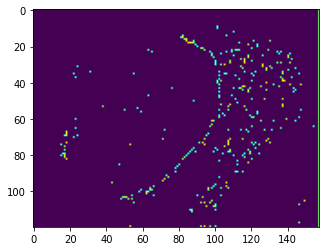

In [29]:
combine_plot = np.reshape(combine[:18960], (120, 158))
plt.imshow(combine_plot)

In [ ]:
df = pd.DataFrame(combine)
df.to_csv('/content/drive/MyDrive/combined_prediction.csv')

In [31]:
count_true_combine/total_true

0.014597315742247059